In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

Episode 100/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.9512
Episode 200/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.9048
Episode 300/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.8607
Episode 400/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.8187
Episode 500/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.7788
Episode 600/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.7408
Episode 700/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.7046
Episode 800/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.6703
Episode 900/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.6376
Episode 1000/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.6065
Episode 1100/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Rate: 0.5769
Episode 1200/50000, Avg Reward: -200.00, Avg Steps: 200.00, Exploration Ra

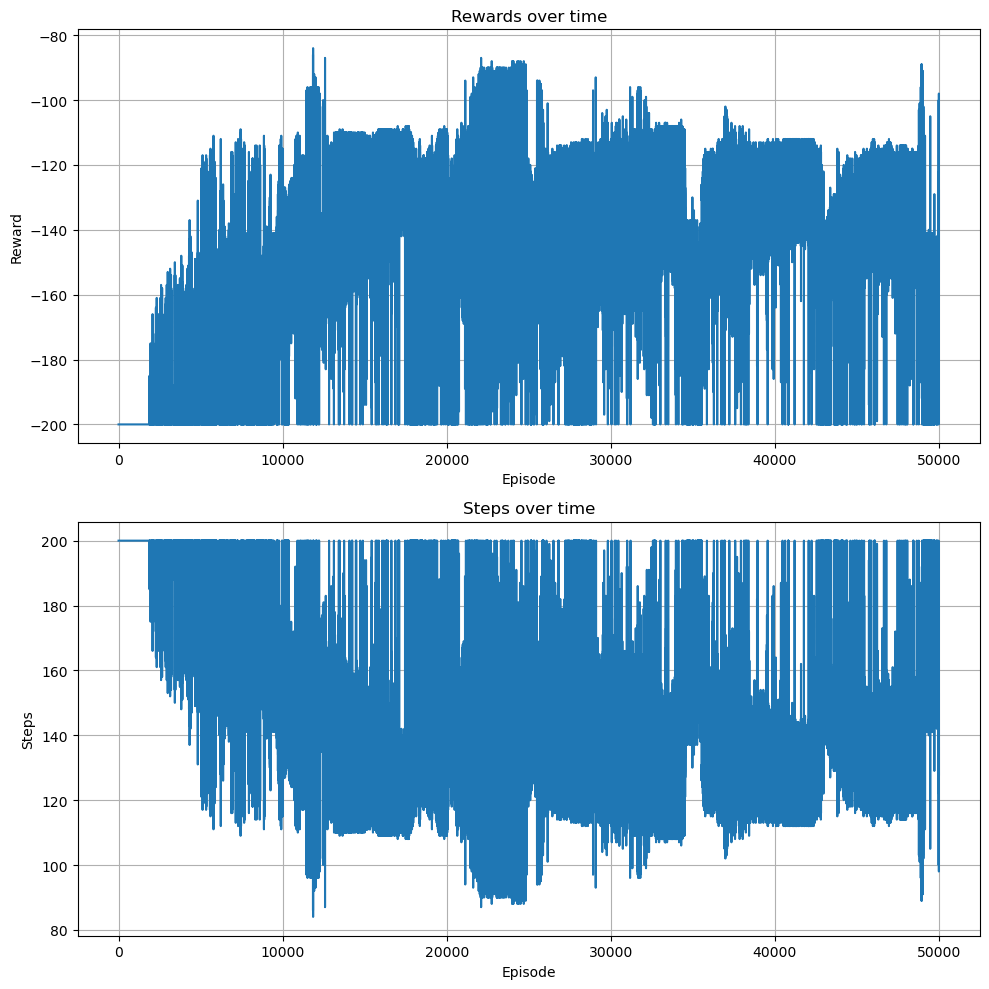

In [12]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.0005):

        self.env = env 
        self.learning_rate = learning_rate  # Alpha
        self.discount_factor = discount_factor  # Gamma
        self.exploration_rate = exploration_rate  # Epsilon
        self.exploration_min = 0.01
        self.exploration_decay = exploration_decay


        # Discretize the continous state space
        self.pos_bins = np.linspace(-1.2, 0.6, 30)
        self.vel_bins = np.linspace(-0.07,0.07,30)


        # Initialize Q-table
        self.q_table = np.zeros((30,30, env.action_space.n))


    def discretize_state(self,state):

        #Convert continous state to discrete state
        pos_idx = np.digitize(state[0], self.pos_bins)
        vel_idx = np.digitize(state[1], self.vel_bins)


         # Get the dimensions of the Q-table
        q_table_pos_size = self.q_table.shape[0] # Should be 20 (num_pos_bins)
        q_table_vel_size = self.q_table.shape[1] # Should be 20 (num_vel_bins)

        # If digitize returns an index equal to the size (because value >= last bin edge),
        # map it to the last valid index (size - 1).
        if pos_idx == q_table_pos_size:
            pos_idx = q_table_pos_size - 1 # Map index 20 to 19
        if vel_idx == q_table_vel_size:
            vel_idx = q_table_vel_size - 1 # Map index 20 to 19

        # Ensure indices are not negative (shouldn't happen if state is within bounds, but safe)
        pos_idx = max(0, pos_idx)
        vel_idx = max(0, vel_idx)

        return pos_idx, vel_idx

    def select_action(self,state):

        #Epsilon-greedy action selection
        if np.random.random() < self.exploration_rate:
            return self.env.action_space.sample() # Explore: random action
        else:
            discrete_state = self.discretize_state(state)
            return np.argmax(self.q_table[discrete_state]) # Exploit: best action

    def update_q_value(self, state, action, reward, next_state, done):
        # Get the discrete representations
        # discrete_state = self.discretize_state(state)
        # discrete_next_state = self.discretize_state(next_state)
        
        # Current Q-value
        # current_q = self.q_table[discrete_state][action]
        
        # Maximum Q-value for the next state
        # if done:
        #     max_next_q = 0
        # else:
        #     max_next_q = np.max(self.q_table[discrete_next_state])
        
        # Bellman equation for Q-value update
        # new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        
        # Update Q-table
        # self.q_table[discrete_state][action] = new_q
        
        # Shape the reward to provide more learning signal
        # Reward improvement in position (getting closer to the goal at 0.5)
        shaped_reward = reward
        if next_state[0] > state[0] and next_state[0] > -0.4:
            # Reward gaining height on the right side of the valley
            shaped_reward += (next_state[0] - state[0]) * 10
        
        # Rest of the update stays the same...
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        current_q = self.q_table[discrete_state][action]
        
        if done:
            max_next_q = 0
        else:
            max_next_q = np.max(self.q_table[discrete_next_state])
        
        new_q = current_q + self.learning_rate * (shaped_reward + self.discount_factor * max_next_q - current_q)
        self.q_table[discrete_state][action] = new_q
        

    def decay_exploration(self):

        # Reduce exploration rate over time
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= (1- self.exploration_decay)
        # Optional: Make sure it doesn't go below min
        # self.exploration_rate = max(self.exploration_min, self.exploration_rate)


# Function to train the agent
def train_agent(env, agent, episodes=20000):

    rewards = []
    steps = []

    for episode in range(episodes):

        state,_ = env.reset()
        done=False
        total_reward = 0
        step_count = 0

        while not done:

            # Select and perform action
            action = agent.select_action(state)
            next_state, reward, terminated, truncated,info= env.step(action)

            current_step_done = terminated or truncated


            # Update Q-value
            agent.update_q_value(state, action, reward, next_state, current_step_done)

            # Move next state
            state = next_state

            # Update reward
            total_reward += reward

            # Update step count
            step_count += 1

            done = current_step_done # Update 'done' so the while loop can eventually exit
        
        # Decay exploration rate
        agent.decay_exploration()

        # Store results
        rewards.append(total_reward)
        steps.append(step_count)

        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            avg_steps = np.mean(steps[-100:])
            print(f"Episode {episode+1}/{episodes}, Avg Reward: {avg_reward:.2f}, Avg Steps: {avg_steps:.2f}, Exploration Rate: {agent.exploration_rate:.4f}")

    return rewards, steps


def plot_learning_curve(rewards, steps):

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

    #Plot rewards
    ax1.plot(rewards, label='Rewards')
    ax1.set_title('Rewards over time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(True)

    #Plot steps
    ax2.plot(steps, label='Steps')
    ax2.set_title('Steps over time')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Create and train agent
env = gym.make('MountainCar-v0')
agent = QLearningAgent(env)
rewards, steps = train_agent(env, agent, episodes=50000)

# Plot learning curve
plot_learning_curve(rewards, steps)


    
    
    
    

        
            
            

    

## Init


class QLearningAgent:: This line declares that we are creating a new type of object, a blueprint called QLearningAgent. Anything indented underneath belongs to this blueprint.

def __init__(self, ...): This defines the special initialization method (the constructor). It's automatically called when you create a QLearningAgent object.

self: This is a convention in Python classes. It represents the specific agent object being created. When we write self.something = value, we are storing value inside that specific agent object.

env: This is the first input needed when creating the agent. We must provide the Gymnasium environment (like the env for MountainCar we created before). The agent needs this to know about the game's rules (like the number of actions).

learning_rate=0.1 (Alpha, α):

    This is a Q-learning parameter. It controls how much the agent updates its knowledge based on new experiences.

    A higher value means learning faster but potentially being more sensitive to noisy or misleading single experiences.

    A lower value means learning slower but potentially more stable.

    =0.1 means if you don't specify a learning rate when creating the agent, it will default to 0.1.

discount_factor=0.99 (Gamma, γ):

    Another crucial Q-learning parameter. It determines how much the agent cares about future rewards compared to immediate rewards.

    A value close to 1 (like 0.99) means the agent values future rewards highly (it's farsighted). This is common in tasks where the goal takes many steps.

    A value close to 0 means the agent mostly cares about the very next reward (it's shortsighted).

    =0.99 sets a default value.

exploration_rate=1.0 (Epsilon, ε):

    This controls the agent's exploration vs. exploitation trade-off using a strategy called "epsilon-greedy".

    An exploration_rate of 1.0 means the agent starts by choosing actions completely randomly (100% exploration). This is important initially so it discovers different parts of the game.

    As the agent learns, we'll decrease this value, so it starts exploiting the knowledge it has gained (choosing actions it thinks are best) more often.

    =1.0 sets the default starting value.

exploration_decay=0.01:

    This controls how quickly the exploration_rate (epsilon) decreases during training. Each time we potentially decay epsilon, we might subtract a small amount or multiply by a factor slightly less than 1. This value influences that decay process.

    =0.01 sets a default decay rate.

self.env = env ...


These lines take the input parameters (like env, learning_rate, etc.) and store them as attributes of the agent object using self.. This means the agent can remember and use these values later in other methods (like when choosing an action or learning).

self.exploration_min = 0.01: We also define a minimum value for epsilon. We usually don't want exploration to stop completely, so we prevent epsilon from decaying below this small value (e.g., 0.01 or 1%).


self.pos_bins and self.vel_bins

The Problem: Remember that MountainCar's state (position, velocity) consists of continuous numbers. Basic Q-learning works best with a finite number of discrete states (like squares on a chessboard). It needs a way to map the infinite possible continuous states into a limited number of "boxes" or categories. This process is called discretization.

self.pos_bins = np.linspace(-1.2, 0.6, 20):

        np.linspace(start, stop, num): Creates a NumPy array of num evenly spaced values starting from start and ending at stop.

        We use the known limits of the position from env.observation_space.low[0] (-1.2) and env.observation_space.high[0] (0.6).

        We divide this entire position range into 20 segments or "bins". self.pos_bins stores the boundaries of these bins. This allows us to figure out which bin (0-19) a specific continuous position falls into.

self.vel_bins = np.linspace(-0.07, 0.07, 20):

        Similarly, we divide the velocity range (-0.07 to 0.07) into 20 bins using np.linspace

Q-TABLE

The Q-Table: This is the core data structure for Q-learning. It's essentially a big lookup table where the agent will store its learned knowledge.

        The rows/indices of the table represent the states.

        The columns (or the last dimension here) represent the actions.

        The value stored at q_table[state, action] is the agent's current estimate of the total future reward it can get if it takes that action while in that state, and then follows its strategy optimally afterward. This is the "Q-value" (Quality value).

np.zeros(...): We create a NumPy array filled entirely with zeros. This means the agent starts with absolutely no prior knowledge – it assumes all actions in all states have a value of 0 initially.

(20, 20, env.action_space.n): This defines the shape of the Q-table:

        20: One dimension for the 20 discrete position bins we created.

        20: Another dimension for the 20 discrete velocity bins.

        env.action_space.n: The last dimension represents the possible actions. env.action_space.n gets the number of actions directly from the environment (which is 3 for MountainCar).

So, self.q_table is a 3-dimensional table. To look up a Q-value, you'll need a position bin index (0-19), a velocity bin index (0-19), and an action index (0-2).

## Discretize_State

Purpose: This method acts like a translator. It takes the continuous state received from the environment and converts it into the discrete state indices that correspond to our Q-table's dimensions.

def discretize_state(self, state):: Defines the method. It takes the agent itself (self) and the state (the NumPy array like [-0.5, 0.02] received from env.step() or env.reset()) as input.


state[0]: This accesses the first element of the input state array, which is the car's position.

self.pos_bins: This accesses the position bin boundaries we created in the __init__ method (the np.linspace array for position).

np.digitize(state[0], self.pos_bins): This is the core of the conversion for position.

        np.digitize(value, bins): This NumPy function takes a value (the car's position) and finds which bin it falls into based on the provided bins boundaries (self.pos_bins).

        It returns the index of the bin. For example, if self.pos_bins divides the range into 20 segments (indices 0 to 19), and the car's position state[0] falls into the 5th segment, this function will return 5.

pos_idx = ...: We store the resulting position bin index in the variable pos_idx.

vel_idx = np.digitize(state[1], self.vel_bins): We do the exact same thing for the velocity:

        state[1]: Get the car's velocity.

        self.vel_bins: Use the velocity bin boundaries defined in __init__.

        np.digitize(...): Find the index of the bin the velocity falls into.

        Store the result in vel_idx.

return pos_idx, vel_idx: The method returns the two calculated indices. These indices (e.g., (5, 12)) now represent the discrete state of the car, suitable for use with our Q-table.

## select_action


Purpose: This method decides which action the agent should take (push left, do nothing, push right) when it's in a given state. It implements the Epsilon-Greedy strategy.

Def select_action(self, state):: Defines the method. Takes the agent (self) and the current continuous state from the environment as input.



Epsilon-Greedy Logic: The agent needs to balance:

        Exploration: Trying random actions to discover potentially better strategies.

        Exploitation: Using the knowledge it already has (in the Q-table) to choose the action it currently thinks is best.

if np.random.random() < self.exploration_rate::

        np.random.random(): Generates a random floating-point number between 0.0 and 1.0.

        self.exploration_rate (Epsilon, ε): Remember this value from __init__? It starts high (e.g., 1.0) and usually decreases over time during training.

        The Check: If the random number is less than epsilon, the condition is True, and the agent decides to explore.

        Think of it like flipping a weighted coin. There's an epsilon probability of landing on "explore".

return self.env.action_space.sample() # Explore: random action:

        If exploring, the agent simply chooses a random action (0, 1, or 2) using the environment's helper function, just like in the initial random script. It ignores its Q-table knowledge for this step.

else::

        If the random number was greater than or equal to epsilon, the agent decides to exploit.

discrete_state = self.discretize_state(state):

        Crucial Step: Before the agent can exploit its knowledge, it needs to know which entry in the Q-table corresponds to the current continuous state. It calls the discretize_state method we just discussed to get the pos_idx and vel_idx.

self.q_table[discrete_state]:

        This uses the discrete_state tuple (e.g., (5, 12)) to access the Q-table.

        Remember self.q_table has shape (20, 20, 3).

        self.q_table[(5, 12)] (or self.q_table[5, 12]) retrieves a small array containing the Q-values for all possible actions (0, 1, and 2) from this specific discrete state. For example, it might get [-15.3, -20.1, -12.5], representing the estimated future rewards for taking action 0, 1, or 2 respectively from state (5, 12).

np.argmax(...):

        This NumPy function finds the index of the maximum value in an array.

        In our example [-15.3, -20.1, -12.5], the maximum value is -12.5, which is at index 2. So, np.argmax would return 2.

return np.argmax(...) # Exploit: best action:

        The agent returns the action index (0, 1, or 2) that corresponds to the highest Q-value for the current discrete state. This is the action the agent currently believes is the best choice based on its learned experience.

## Update_Q_Value


Purpose: To adjust the value stored in the Q-table for the specific state-action pair that was just experienced, based on the reward received and the potential future rewards. This is the core learning step.

Get discrete representations: As before, the Q-table works with discrete indices, not continuous states.

discrete_state = self.discretize_state(state): Convert the starting continuous state into its discrete indices (e.g., (5, 12)).

discrete_next_state = self.discretize_state(next_state): Convert the resulting continuous state into its discrete indices (e.g., (6, 13)).

Current Q-value: Get the agent's current belief about the value of the action it just took, before learning from this new experience.

self.q_table[discrete_state]: Access the row(s) in the Q-table corresponding to the discrete_state (e.g., (5, 12)). This gives the Q-values for all actions from that state.

[action]: From those values, select the specific Q-value for the action that was actually taken (e.g., if action was 2, get the third value).

current_q = ...: Store this existing Q-value. This is the value we are about to update.

Maximum Q-value for next state: This is a crucial part of Q-learning. We need to estimate the best possible value the agent could get starting from the next_state.

if done:: Check the done flag (which combines terminated and truncated from env.step).

        If done is True, it means the episode ended after taking the action. There are no further steps or future rewards from next_state.

        max_next_q = 0: In this case, the maximum future value from next_state is simply 0.

else:: If the episode is not finished:

        self.q_table[discrete_next_state]: Access the Q-values for all possible actions from the discrete_next_state.

        np.max(...): Find the maximum Q-value among those actions. This represents the agent's current estimate of the best possible value it can achieve from that next state (assuming it acts optimally/greedily from then on).

        max_next_q = ...: Store this maximum value.

Bellman equation...: This is the famous Q-learning update rule, derived from the Bellman equation. It calculates the new estimate for the Q-value. Let's break down the formula: new_q = current_q + alpha * (target - current_q)

        reward + self.discount_factor * max_next_q: This part is the Target Q-value. It's our improved estimate of what the Q-value should be. It's calculated as:

            reward: The immediate reward we actually received.

            self.discount_factor * max_next_q: The discounted value of the best action from the next state. We multiply max_next_q by self.discount_factor (gamma, γ) because future rewards are usually considered slightly less valuable than immediate ones.

        (reward + self.discount_factor * max_next_q - current_q): This is the Temporal Difference (TD) Error. It measures the difference between the new target value and our old estimate (current_q). It tells us how much "surprise" or error there was in our previous prediction.

        self.learning_rate * (TD Error): We multiply the TD Error by the self.learning_rate (alpha, α). This determines how much we adjust our old estimate based on the error. A smaller alpha means smaller adjustments (slower learning), a larger alpha means bigger adjustments (faster, potentially unstable learning).

        current_q + ...: The new_q is calculated by taking the current_q and adding the adjustment amount (the learning rate multiplied by the TD error).

Update Q-table: The final, crucial step.

self.q_table[discrete_state][action] = new_q: We replace the old Q-value in the Q-table (at the location corresponding to the discrete_state and the action taken) with the newly calculated new_q. This is how the agent learns and improves its Q-table over time!

Analogy: 

Imagine you estimated it takes 30 minutes (current_q) to get home. You walk 5 minutes (reward is -5 if we think of time as negative reward), and from your new location, you now estimate it will take another 20 minutes (max_next_q). Let's say discount_factor is 1 (no discount) and learning_rate is 0.1.

        Target = -5 + 1 * 20 = 15 minutes remaining (this is wrong for time, but illustrates the math!) Let's use actual reward: Reward = -5. Estimate from next state = -20. Target = -5 + 1*(-20) = -25.

        TD Error = Target - current_q = -25 - (-30) = 5. Your old estimate was 5 minutes too pessimistic.

        Update = learning_rate * TD Error = 0.1 * 5 = 0.5.

        new_q = current_q + Update = -30 + 0.5 = -29.5. Your new estimate for the original starting point is now -29.5 minutes. You slightly adjusted your initial estimate based on the new information.

## Update_q Optimized

Reward Shaping into the update_q_value method. This is a common technique used to try and speed up learning in environments with sparse rewards (like MountainCar, where you only get significant feedback implicitly by finishing faster).

shaped_reward = reward: You correctly start with the base reward from the environment (-1).

Progress Towards Goal Reward:

        if next_state[0] > -0.4 and next_state[0] > state[0]: shaped_reward += (next_state[0] - state[0]) * 10

        Logic: If the car is past the bottom of the valley (> -0.4) and is moving to the right (next_state[0] > state[0]), give it a positive reward proportional to how far right it moved, scaled by 10.

        Goal: Encourage the agent to move up the right slope once it gets there.

Momentum Building Reward:

        if abs(next_state[1]) > abs(state[1]): shaped_reward += 0.5

        Logic: If the absolute velocity (speed) increased compared to the previous step, give a small positive bonus.

        Goal: Encourage the key mechanic needed to solve the environment – building momentum.

Goal Achievement Reward:

        if done and next_state[0] >= 0.5: shaped_reward += 10

        Logic: If the episode is finished (done) and the car reached the goal position (>= 0.5), give a large positive bonus.

        Goal: Make the terminal goal state much more valuable than just getting a reward of 0 (which happens implicitly in the original env by stopping the -1s).

## Decay_exploration

Purpose: 

To gradually decrease the exploration_rate (epsilon, ε) over the course of training. This makes the agent shift from exploring randomly initially to exploiting its learned knowledge more often later on.

Reduce exploration rate...: Explains the goal.

if self.exploration_rate > self.exploration_min:: Check if the current exploration rate is still higher than the minimum allowed value (self.exploration_min, e.g., 0.01) set during initialization. We don't want exploration to completely stop.

self.exploration_rate *= (1 - self.exploration_decay): If it's above the minimum, we reduce epsilon.

        self.exploration_decay: The small decay factor (e.g., 0.01) set during initialization.

        (1 - self.exploration_decay): This calculates a multiplier slightly less than 1 (e.g., 1 - 0.01 = 0.99).

        *= ...: This multiplies the current self.exploration_rate by this factor. For example, if epsilon was 0.50 and the factor is 0.99, the new epsilon becomes 0.50 * 0.99 = 0.495. This causes epsilon to decrease exponentially over time (faster at the beginning, slower later).

Optional: ... self.exploration_rate = max(...): This commented-out line is another way to ensure epsilon doesn't go below self.exploration_min. The multiplication method usually achieves this naturally if decay is small, but explicitly using max is safer.

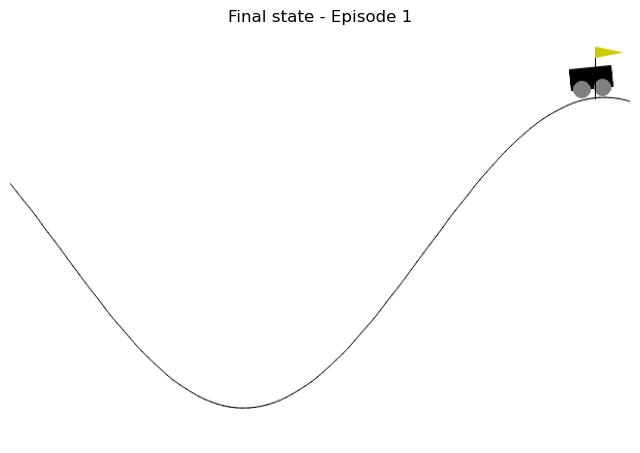

AttributeError: 'NoneType' object has no attribute 'to_jshtml'

In [21]:
def visualize_agent_notebook(env_name, agent, episodes=1):
    # For notebook environments
    from IPython import display
    
    env = gym.make(env_name, render_mode='rgb_array')
    
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        frames = []
        
        while not done:
            # Render and store frame
            frame = env.render()
            frames.append(frame)
            
            # Select best action using learned policy
            discrete_state = agent.discretize_state(state)
            action = np.argmax(agent.q_table[discrete_state])
            
            # Perform action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Move to next state
            state = next_state
            
            # Display the current frame
            if len(frames) % 10 == 0:  # Show every 10th frame to speed up display
                plt.figure(figsize=(8, 6))
                plt.imshow(frame)
                plt.axis('off')
                display.display(plt.gcf())
                display.clear_output(wait=True)
                plt.close()
        
        # Show the final frame
        plt.figure(figsize=(8, 6))
        plt.imshow(frames[-1])
        plt.axis('off')
        plt.title(f"Final state - Episode {episode+1}")
        plt.show()
    
    env.close()

# Call the visualization function
animation = visualize_agent_notebook('MountainCar-v0', agent, episodes=1)

# Display the animation
from IPython.display import HTML
HTML(animation.to_jshtml())
    